# Otimização de parâmetros

In [11]:
from ztools.ntf import telegram # apagar - biblioteca particular

from agent import Agent
from environment import Environment
from utils import plot_evolution, get_config

import os
import re
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf

from tqdm import tqdm
from datetime import datetime

In [34]:
param_grid = {
    #'theta_disc': np.arange(80, 101, 10),
    #'vel_disc': np.arange(90, 111, 10),
    'n_episodes': np.arange(2000, 6000, 500),
    # 'min_experiences': np.arange(0, 1000, 300),
    # 'max_experiences': np.arange(4000, 15000, 3000),
    # 'decay': np.arange(0.001, 0.05, 0.005),
    # 'batch_size': np.arange(0, 1001, 1000),
}

n = 1
for param in param_grid:
    n *= len(param_grid[param])
print('Número de combinações:', n)

Número de combinações: 8


In [35]:
grid = []
start = True
for param in param_grid:
    news = []
    for value in param_grid[param]:
        if start:
            conf = {param: value}
            news.append(conf)
        else:
            for conf in grid:
                new_conf = conf.copy()
                new_conf[param] = value
                news.append(new_conf)
    grid = news
    start = False

In [27]:
for i, conf in enumerate(grid):
    print(f'({i+1}/{len(grid)})')
    env_settings = {
        'theta_disc': get_config('theta_dict', 91, int),  # número de pontos de discretização do ângulo de lancamento
        'vel_disc': get_config('vel_disc', 100, int),  # número de pontos de dicretização da velocidade de lancamento
        'max_dist': 50,  # máxima distancia possivel para o alvo
        'target_len': 'random'  # comprimento do alvo, isto e, tolerância absoluta para sucesso
    }

    n_states = 2

    n_episodes = get_config('n_episodes', 4000, int)  # número de episodios a serem executados
    decay = get_config('decay', 0.01, float)  # decaimento da taxa de aleatoriedade

    agent_settings = {
        'num_states': 2,  # número de parâmetros de um estado = (distancia)
        'gamma': 0,  # incremento por ações futuras
        'min_experiences': get_config('min_experiences', 900, int),  # mínimo de experiências aleatórias
        'max_experiences': get_config('max_experiences', 13000, int),  # máximo de experiências aleatórias
        'batch_size': 0  # tamanho do pacote aleatório a ser treinado em cada episódio
    }

    total_reward = 0  # recompensa total
    min_eps = 0.01  # mínima taxa de aleatoriedade
    max_eps = 1  # máxima taxa de aleatoriedade
    verbose = 0  # tipo de output visível após a execução
    pack_size = 5  # números de episódios considerados em cada média no plot resultante

    data = {
        'agent_settings': agent_settings,
        'env_settings': env_settings,
        'training_settings': {
            'n_states': n_states,
            'n_episodes': n_episodes,
            'min_eps': min_eps,
            'max_eps': max_eps,
            'decay': decay
        }
    }

    env = Environment(**env_settings)  # ambiente configurado com parâmetros definidos

    with tf.Session() as sess:
        # saver = tf.train.Saver()
        agent = Agent(sess, len(env.actions), **agent_settings)  # agente configurado com acoes definidas
        sess.run(agent.init)  # inicalização da sessão para o agente (?)

        all_episodes = range(n_episodes)  # index de episódios

        if verbose == 0:
            all_episodes = tqdm(all_episodes)  # barra de progressão por episódios

        start_training = time.time()

        for i in all_episodes:
            eps = min_eps + (max_eps - min_eps) * np.exp(-decay * i)  # cálculo da taxa de aleatoriedade

            state = env.reset()  # gera um novo ambiente = novo alvo
            action = agent.choose_action(state, eps)  # toma uma ação dado o ambiente
            reward, next_state = env.step(action, state)  # calcula os efeitos da ação tomada
            agent.add_experience(state, action, reward, next_state)  # absorve a experiência obtida
            agent.train()  # treino

            if verbose == 1 and i % 100 == 0:
                print("Reward:", reward)

        data['results'] = {
            'training_rewards': agent.rewards,
            'training_time': time.time() - start_training
        }

        print("\nLast 100 episode rewards average:", sum(agent.rewards[-100:]) / 100)
        print("Total reward:", sum(agent.rewards))
        print('Total training time:', data['results']['training_time'], 's')

        # saver.save(sess, 'data/test_session')

        # plot_evolution(agent.rewards, pack_size, 'Treino')

        print('\nTesting.\n')

        n_episodes = 1000

        rewards = []

        for i in tqdm(range(n_episodes)):
            state = env.reset()  # gera um novo ambiente = novo alvo
            action = agent.choose_action(state, 0)  # toma uma ação dado o ambiente
            reward, next_state = env.step(action, state)  # calcula os efeitos da ação tomada
            rewards.append(reward)

        data['results']['testing_rewards'] = rewards
        data['date'] = datetime.today().isoformat()

        if 'data' not in os.listdir():
            os.mkdir('data')
        filename = re.sub(r'[\-\:\.]', '', data['date'])
        with open(f"data/{filename}.json", 'w') as f:
            try:
                json.dump(data, f)
            except Exception as e:
                telegram('Erro no carregamento dos dados.\n\n' + str(e)) # apagar - biblioteca particular
                raise e

        # plot_evolution(rewards, pack_size, 'Teste')

        print('\nScore médio:', sum(rewards)/n_episodes)
telegram('GridSearch completo.') # apagar - biblioteca particular

(1/10)


 21%|███████▏                           | 206/1000 [00:00<00:00, 2039.66it/s]


Last 100 episode rewards average: 34.01747963219155
Total reward: 31067.57346012711
Total training time: 521.6069967746735 s

Testing.



100%|██████████████████████████████████| 1000/1000 [00:00<00:00, 1708.11it/s]



Score médio: 40.857129802009155
(2/10)


 22%|███████▋                           | 218/1000 [00:00<00:00, 2179.96it/s]


Last 100 episode rewards average: 41.8453629958977
Total reward: 58291.83341408594
Total training time: 514.1710028648376 s

Testing.



100%|██████████████████████████████████| 1000/1000 [00:00<00:00, 2109.64it/s]



Score médio: 38.64470175220358
(3/10)


 19%|██████▊                            | 194/1000 [00:00<00:00, 1939.98it/s]


Last 100 episode rewards average: 40.97408985601743
Total reward: 48557.090127614116
Total training time: 514.2984008789062 s

Testing.



100%|██████████████████████████████████| 1000/1000 [00:00<00:00, 1841.63it/s]



Score médio: 37.198726169477936
(4/10)


 21%|███████▏                           | 207/1000 [00:00<00:00, 2069.94it/s]


Last 100 episode rewards average: 39.52668057232902
Total reward: 62167.16240643356
Total training time: 514.2338888645172 s

Testing.



100%|██████████████████████████████████| 1000/1000 [00:00<00:00, 1719.23it/s]



Score médio: 40.35995335759527
(5/10)


 20%|███████▏                           | 205/1000 [00:00<00:00, 2049.73it/s]


Last 100 episode rewards average: 43.76513881756418
Total reward: 62166.243569249586
Total training time: 515.8837239742279 s

Testing.



100%|██████████████████████████████████| 1000/1000 [00:00<00:00, 1883.23it/s]



Score médio: 43.02431485200273
(6/10)


 21%|███████▎                           | 208/1000 [00:00<00:00, 2059.42it/s]


Last 100 episode rewards average: 37.64990926273465
Total reward: 51164.52487493741
Total training time: 596.6334843635559 s

Testing.



100%|██████████████████████████████████| 1000/1000 [00:00<00:00, 1996.01it/s]



Score médio: 41.723567090189036
(7/10)


 16%|█████▋                             | 163/1000 [00:00<00:00, 1629.85it/s]


Last 100 episode rewards average: 23.73216034765341
Total reward: 31880.523048637417
Total training time: 603.89302277565 s

Testing.



100%|██████████████████████████████████| 1000/1000 [00:00<00:00, 1675.05it/s]



Score médio: 26.672436317222783
(8/10)


 34%|████████████                       | 343/1000 [00:00<00:00, 1696.97it/s]


Last 100 episode rewards average: 31.92697051998757
Total reward: 63570.6699209779
Total training time: 601.0880472660065 s

Testing.



100%|██████████████████████████████████| 1000/1000 [00:00<00:00, 1694.92it/s]



Score médio: 35.09720096396326
(9/10)


 14%|████▉                              | 141/1000 [00:00<00:00, 1396.05it/s]


Last 100 episode rewards average: 41.26225814547098
Total reward: 47186.477496394116
Total training time: 617.7129123210907 s

Testing.



100%|██████████████████████████████████| 1000/1000 [00:00<00:00, 1555.19it/s]



Score médio: 43.436153196753125
(10/10)


 28%|█████████▊                         | 279/1000 [00:00<00:00, 1380.59it/s]


Last 100 episode rewards average: 33.048131025526175
Total reward: 57194.402190778535
Total training time: 611.9169886112213 s

Testing.



100%|██████████████████████████████████| 1000/1000 [00:00<00:00, 1344.07it/s]



Score médio: 40.24068656102817


In [28]:
data = []
for file in os.listdir('data')[-len(grid):]:
    data.append(json.loads(open(f'data/{file}').read()))

In [29]:
df = {'n_episodes': [], 'reward': [], 'training_time': []}
for d in data:
    df['n_episodes'].append(d['training_settings']['n_episodes'])
    df['reward'].append(np.mean(d['results']['testing_rewards']))
    df['training_time'].append(d['results']['training_time'])
    
result = pd.DataFrame(df)
if 'grid_data' not in os.listdir():
    os.mkdir('grid_data')
result.to_csv(f"grid_data/{len(os.listdir('grid_data'))}.csv")
result

,decay,reward,training_time
0,0.001,40.857130,521.606997
1,0.006,38.644702,514.171003
2,0.011,37.198726,514.298401
3,0.016,40.359953,514.233889
4,0.021,43.024315,515.883724
5,0.026,41.723567,596.633484
6,0.031,26.672436,603.893023
7,0.036,35.097201,601.088047
8,0.041,43.436153,617.712912
9,0.046,40.240687,611.916989


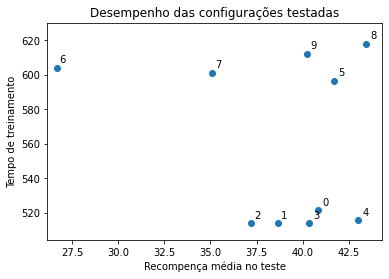

In [30]:
plt.scatter(result['reward'], result['training_time'])
plt.title('Desempenho das configurações testadas')
plt.xlabel('Recompença média no teste')
plt.ylabel('Tempo de treinamento')
[plt.annotate(i, (result['reward'][i], result['training_time'][i]), xytext=(result['reward'][i]*1.005, result['training_time'][i]*1.005)) for i in result.index]
plt.xlim([min(result['reward'].values)/1.02, max(result['reward'].values)*1.02])
plt.ylim([min(result['training_time'].values)/1.02, max(result['training_time'].values)*1.02])
plt.show()

In [ ]:
result.iloc[3]